In [1]:
# importing general necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# models that are fitted on the data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [16]:
# importing the dataset and making some adjustments so it works with the model and the time series split
df = pd.read_csv("../4)Data/combined_dataset_temp.csv").drop(columns=["Unnamed: 0", "GAUL", "M49"])
df["Casualties"] = df["Casualties"].fillna(0)
df["Undernourishment (%)"] = df["Undernourishment (%)"].replace({"<2.5": 0})
df["Current PoU"] = df["Undernourishment (%)"]
df["Undernourishment (%)"] = pd.to_numeric(df["Undernourishment (%)"]).shift(periods=-1)
df = df.drop(index=df.index[19::20])
df = df.dropna().sort_values("Year")

,Area,Year,GDP (MUSD),GNI (MUSD),Food Prod. Index,Temperature,Precipitation,NDVI,Casualties,Undernourishment (%),Current PoU
0,Afghanistan,2001,3598.470576,3598.407195,62.42,286.086560,42.992387,1064.486468,5553.0,45.6,47.8
1,Afghanistan,2002,4141.523943,4134.295420,75.74,285.637743,64.661574,1040.450950,1157.0,40.6,45.6
2,Afghanistan,2003,4729.042179,4721.728965,77.83,284.996151,74.464959,972.493440,944.0,38.0,40.6
3,Afghanistan,2004,5388.482107,5396.722695,75.77,285.864614,66.059247,937.723550,817.0,36.1,38
4,Afghanistan,2005,6220.574147,6231.622214,84.68,284.481630,78.640260,980.545636,1711.0,33.3,36.1
5,Afghanistan,2006,7104.711445,7148.304369,78.42,285.923770,72.733321,897.780870,4982.0,29.8,33.3
6,Afghanistan,2007,9412.161765,9440.635873,85.87,285.201492,71.608064,995.290964,7020.0,26.5,29.8
7,Afghanistan,2008,10236.901594,10280.097552,80.73,285.350686,58.162025,883.213410,5660.0,23.3,26.5
8,Afghanistan,2009,11595.133469,11562.069957,93.57,284.936683,88.609552,983.350877,6499.0,21.2,23.3
9,Afghanistan,2010,14698.889678,14724.781634,93.00,286.093083,71.047817,942.676111,7151.0,20.2,21.2


In [3]:
# Creating training and test data, but not randomly splitting (roughly two years get excluded) and scaling
sc_x = StandardScaler()
sc_y = StandardScaler()

df_model = df.drop(columns=["Area", "Year"])

df_model_x = sc_x.fit_transform(df_model[["GDP (MUSD)", "GNI (MUSD)", "Food Prod. Index", "Temperature", "Precipitation", "NDVI", "Casualties", "Current PoU"]])
df_model_x = pd.DataFrame(df_model_x, columns=["GDP (MUSD)", "GNI (MUSD)", "Food Prod. Index", "Temperature", "Precipitation", "NDVI", "Casualties", "Current PoU"])

df_model_y = sc_y.fit_transform(df_model["Undernourishment (%)"].array.reshape(-1, 1))
df_model_y = pd.DataFrame(df_model_y, columns=["Undernourishment (%)"])

y_train = df_model_y["Undernourishment (%)"].iloc[:-155]
X_train = df_model_x.iloc[:-155]

y_test = df_model_y["Undernourishment (%)"].iloc[-155:]
X_test = df_model_x.iloc[-155:]

In [4]:
# testing different models
dict_regressors = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Linear SVM": SVR(),
    "Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Neural Network": MLPRegressor(max_iter=1000)
}

model_list = [
    "Random Forest",
    "Gradient Boosting",
    "Linear SVM",
    "Nearest Neighbors",
    "Decision Tree",
    "Linear Regression",
    "Ridge Regression",
    "Neural Network"
    ]
model_score = []
model_score_std = []

tscv = TimeSeriesSplit(n_splits=5, test_size=310)

for regressor_name, regressor_value in dict_regressors.items():

    model = regressor_value
    scores = cross_val_score(model, X_train, y_train, cv=tscv)

    model_score.append(scores.mean())
    model_score_std.append(scores.std())

    print(str(regressor_name) + ": %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

model_comparison = pd.DataFrame(
    {'Model': model_list,
     'Average Score': model_score,
     'Standard diviation': model_score_std
    })
model_comparison.to_csv('../4)Data/model_comparison.csv')    

Random Forest: 0.99 accuracy with a standard deviation of 0.00
Gradient Boosting Regressor: 0.99 accuracy with a standard deviation of 0.00
Linear SVM: 0.98 accuracy with a standard deviation of 0.01
Nearest Neighbors: 0.95 accuracy with a standard deviation of 0.01
Decision Tree: 0.98 accuracy with a standard deviation of 0.00
Linear Regression: 0.99 accuracy with a standard deviation of 0.00
Ridge Regression: 0.99 accuracy with a standard deviation of 0.00
Neural Network: 0.99 accuracy with a standard deviation of 0.00


In [5]:
# Compare with normal split, to see how much trend there actually is in the data
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.99 accuracy with a standard deviation of 0.00


In [6]:
# using the best model to predict the test data, after fitting it on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

print("model score on training data:",model.score(X_train, y_train))
print("model score on test data:",model.score(X_test, y_test))

model score on training data: 0.998800122519515
model score on test data: 0.9867542024004833


In [7]:
# making predictions and saving the results
res = pd.DataFrame()
res["Pred. Undernourishment"] = model.predict(X_test)
res = sc_y.inverse_transform(res)

df_result = df[["Area", "Year", "Undernourishment (%)"]].iloc[-155:]
df_result["Pred. Undernourishment"] = res
df_result = df_result.sort_values("Area").rename(columns={"Undernourishment (%)": "Real Undernourishment"}).reset_index()
df_result.to_csv("../4)Data/future_pred_result.csv")

In [8]:
# printing the root mean squared error of the results
rms = np.sqrt(mean_squared_error(df_result["Real Undernourishment"], df_result["Pred. Undernourishment"]))
print("Root mean squared error of one-year ahead prediction: " + str(rms))

Root mean squared error of one-year ahead prediction: 1.3729849986258458


<Figure size 640x480 with 0 Axes>

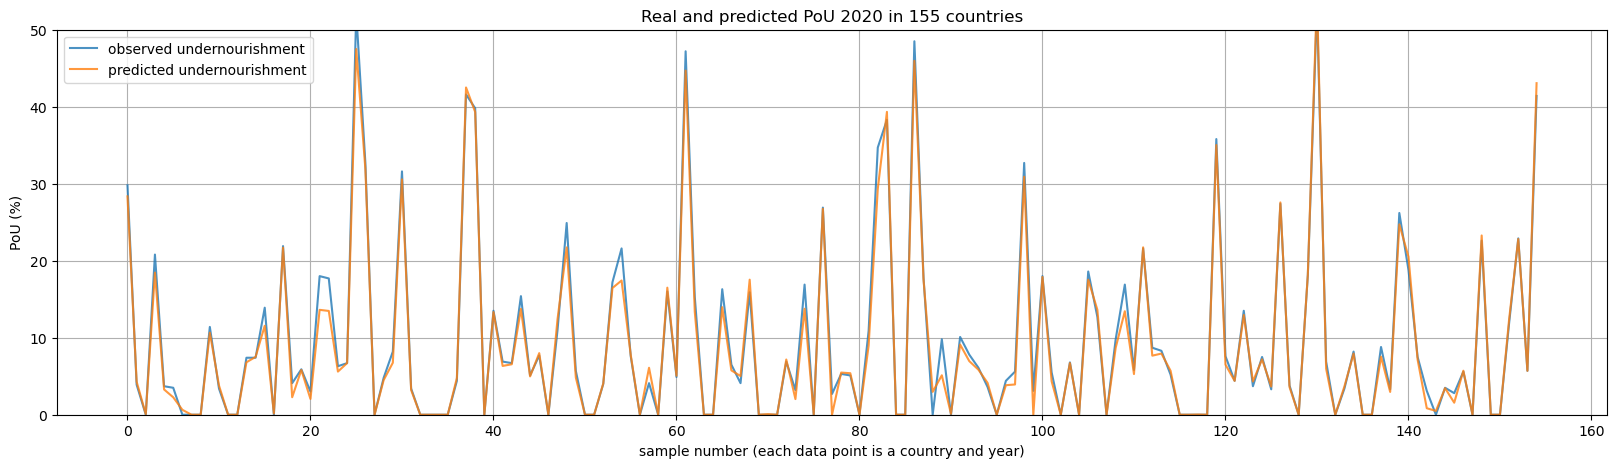

In [9]:
# plotting actual vs predicted undernourishment
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(df_result["Real Undernourishment"], alpha=0.8, label="observed undernourishment")
plt.plot(df_result["Pred. Undernourishment"],alpha=0.8, label="predicted undernourishment")
plt.xlabel("sample number (each data point is a country and year)")
plt.ylabel("PoU (%)")
plt.legend(loc="upper left")
plt.title("Real and predicted PoU 2020 in 155 countries")
plt.ylim(0,50)
plt.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

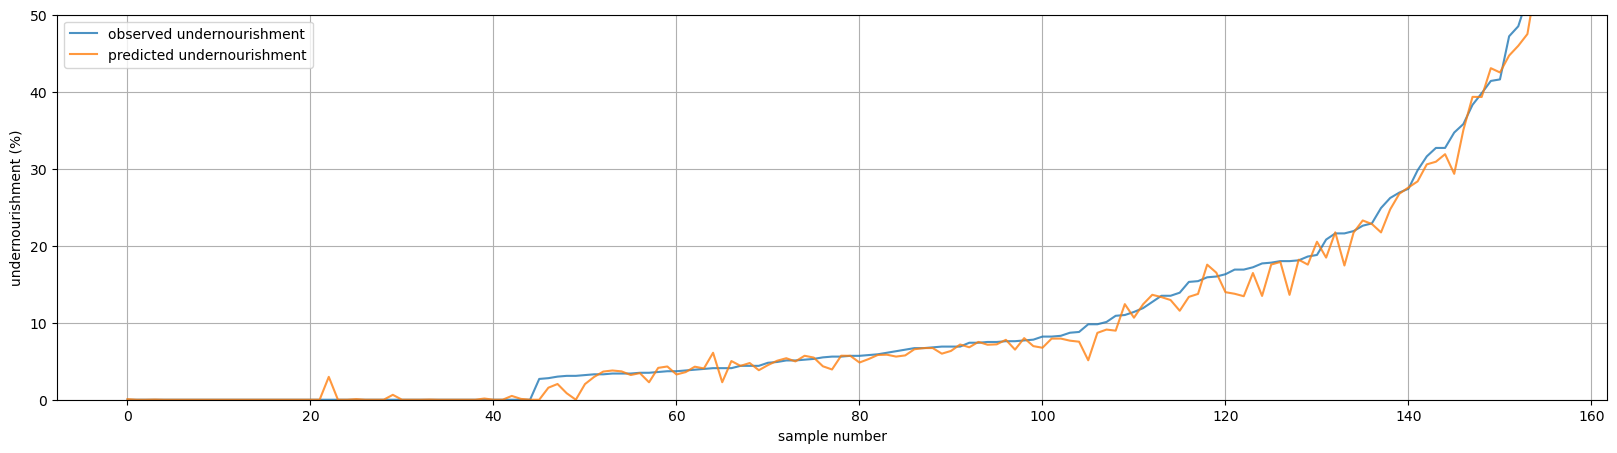

In [10]:
# same thing, but sorting the dataframe by ascending real PoU values first
df_asc = df_result.sort_values(by=["Real Undernourishment"]).reset_index()
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(df_asc["Real Undernourishment"], alpha=0.8, label="observed undernourishment")
plt.plot(df_asc["Pred. Undernourishment"],alpha=0.8, label="predicted undernourishment")
plt.xlabel("sample number")
plt.ylabel("undernourishment (%)")
plt.legend(loc="upper left")
plt.ylim(0,50)
plt.grid()
plt.show()

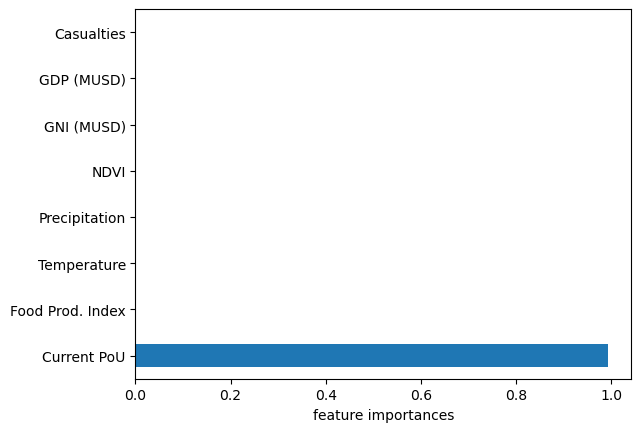

<Figure size 2000x2000 with 0 Axes>

In [13]:
# feature importances in the model later used (all features)
model = RandomForestRegressor()
model.fit(X_train, y_train)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.xlabel("feature importances")
plt.figure(figsize=(10, 10), dpi=200)
plt.show()